<a href="https://colab.research.google.com/github/alivemarin/my-code/blob/main/Node_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##필요한 라이브러리 설치
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-geometric
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphNorm
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.utils import to_networkx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00


In [2]:
hid_dim = 16   #원래는 16
epochs = 1000  #원래는 1000
learning_rate = 0.0001
heads = 8
#변형을 해서 꼭해라.

In [3]:
dataset = Planetoid(root = ' /tmp/Cora', name='Cora')
graph = dataset[0]
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(graph.x)
print(graph.edge_index)
print(graph.y)
graph.num_classes = 7
print(f'Number of classes: {graph.num_classes}')

Processing...


Number of nodes: 2708
Number of edges: 10556
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])
tensor([3, 4, 4,  ..., 3, 3, 3])
Number of classes: 7


Done!


Cora라는 논문 수천개를 가져와서 테스트함.

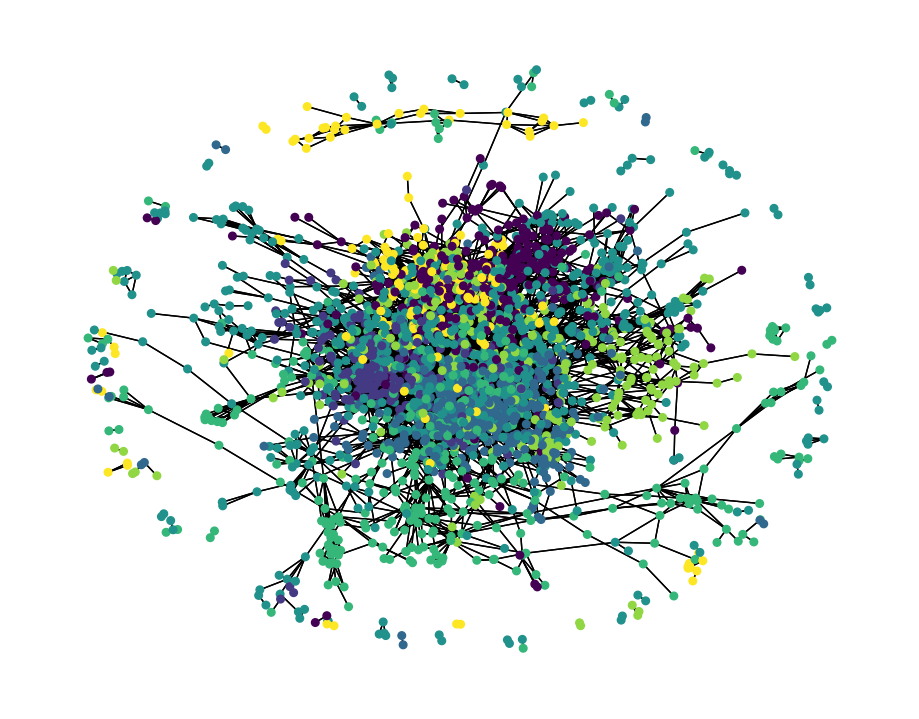

In [4]:
def convert_to_networkx(graph):
  g = to_networkx(graph, node_attrs =["x"])
  y = graph.y.numpy()
  return g, y

def plot_graph(g, y) :
  plt.figure(figsize=(9,7))
  nx.draw_spring(g, node_size = 30, arrows = False, node_color = y)
  plt.show()

g, y = convert_to_networkx(graph)
plot_graph(g, y)

In [5]:
split = T.RandomNodeSplit (num_val=0.1, num_test=0.2)   #0.7은 나머지는 다 훈련용으로 들어감.
graph = split (graph)
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7)

mask크기가 2708이고 "1"개수가 비율 (train은 연습문제, val는 모의고사, test는 본시험) - 측정을 위해서 이렇게 쓴다.

In [6]:
class MyGCN(torch.nn.Module):
    def __init__(self, graph, hid_dim):
        super(MyGCN, self).__init__()
        self.conv1 = GCNConv(graph.num_node_features, hid_dim)
        self.conv2 = GCNConv(hid_dim, hid_dim)
        self.out = Linear(hid_dim, graph.num_classes)

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.softmax(self.out(x), dim=1)
        return x

model = MyGCN(graph, hid_dim)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

##클래스 안의 함수는 바꿔도 됨. optimizer도 바꿔도 됨. loss_function은 불변. 제외


MyGCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


이 로직은 그래프를 GCN으로 돌리는 과정이다.
Relu로 먼저 한번 받고 dropout으로 over-fitting을 줄임.
또 CNN돌리고 relu로 정제
이후 마지막에 softmax로 나눈다. optimizer도 adam으로 썼음.
이 조합은 알아서 이제 하는 것 (선형회귀써도 되고 뭘 쓰던)

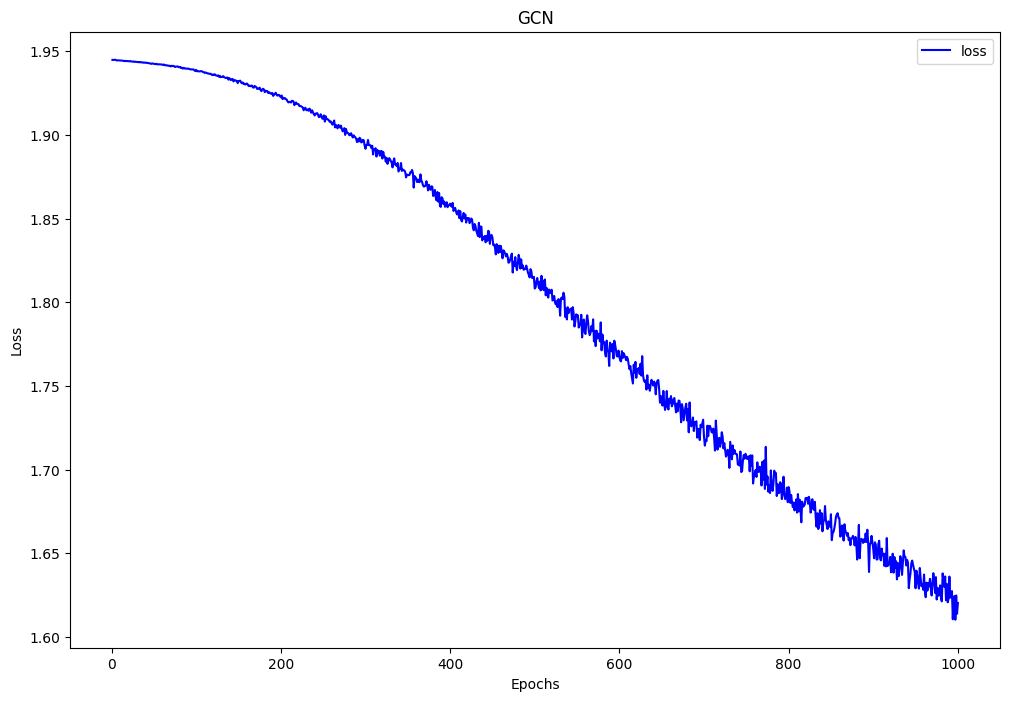

In [7]:
model.train()
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(graph)
    loss = loss_function(out, graph.y)
    loss = loss_function(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(12,8))
plt.title('GCN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
losses_np = np.array(losses)
epoch_range = np.arange(1, epochs+1)
plt.plot(epoch_range, losses_np, color='blue', label='loss')
plt.legend()
plt.show()


In [8]:
##자동 노드 분류

model.eval()

with torch.no_grad():
    out = model(graph)
    pred = out.argmax(dim=1)
    test_correct = (pred[graph.test_mask] == graph.y[graph.test_mask]).sum()
    test_acc = int(test_correct) / int(graph.test_mask.sum())
    print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.7399


In [9]:
class MyGAT(torch.nn.Module):
    def __init__(self, graph, hid_dim, heads):
        super(MyGAT, self).__init__()
        self.conv1 = GATConv(graph.num_node_features, hid_dim, heads)
        self.norm = GraphNorm(hid_dim*heads)
        self.conv2 = GATConv(hid_dim*heads, graph.num_classes, heads = 1)

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.norm(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax (x, dim = 1)
        return x

model = MyGAT(graph, hid_dim, heads)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

##클래스 안의 함수는 바꿔도 됨. optimizer도 바꿔도 됨. loss_function은 불변. 제외

MyGAT(
  (conv1): GATConv(1433, 16, heads=8)
  (norm): GraphNorm(128)
  (conv2): GATConv(128, 7, heads=1)
)


GCN대신 GAT를 넣었고 Normaramlize을 넣음.(정규화로 0~1) standation은 확률로

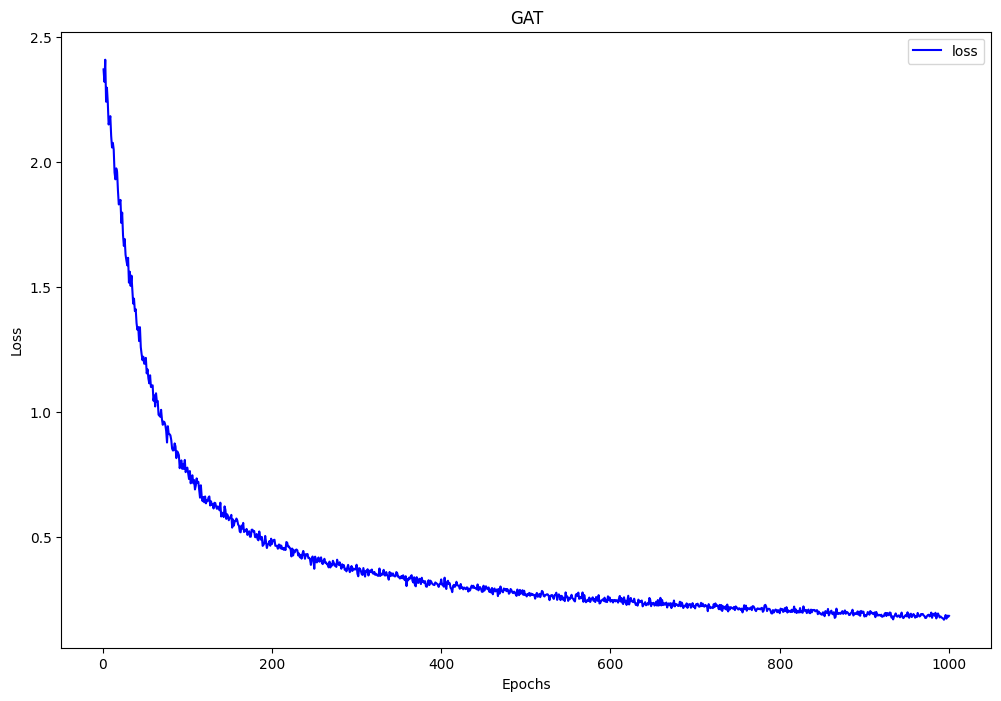

In [10]:
model.train()
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(graph)
    loss = loss_function(out, graph.y)
    loss = loss_function(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(12,8))
plt.title('GAT')
plt.xlabel('Epochs')
plt.ylabel('Loss')
losses_np = np.array(losses)
epoch_range = np.arange(1, epochs+1)
plt.plot(epoch_range, losses_np, color='blue', label='loss')
plt.legend()
plt.show()


In [11]:
##자동 노드 분류

model.eval()

with torch.no_grad():
    out = model(graph)
    pred = out.argmax(dim=1)
    test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]
    test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())
    print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8745


In [12]:
class FNN(torch.nn.Module):
    def __init__(self, graph, hid_dim):
        super(FNN, self).__init__()
        self.lin0 = torch.nn.Linear(graph.num_node_features, hid_dim)
        self.lin1 = torch.nn.Linear(hid_dim, graph.num_classes)

    def forward(self, graph):
        x = self.lin0(graph.x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        return x

model = FNN(graph, hid_dim)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

##클래스 안의 함수는 바꿔도 됨. optimizer도 바꿔도 됨. loss_function은 불변. 제외

FNN(
  (lin0): Linear(in_features=1433, out_features=16, bias=True)
  (lin1): Linear(in_features=16, out_features=7, bias=True)
)


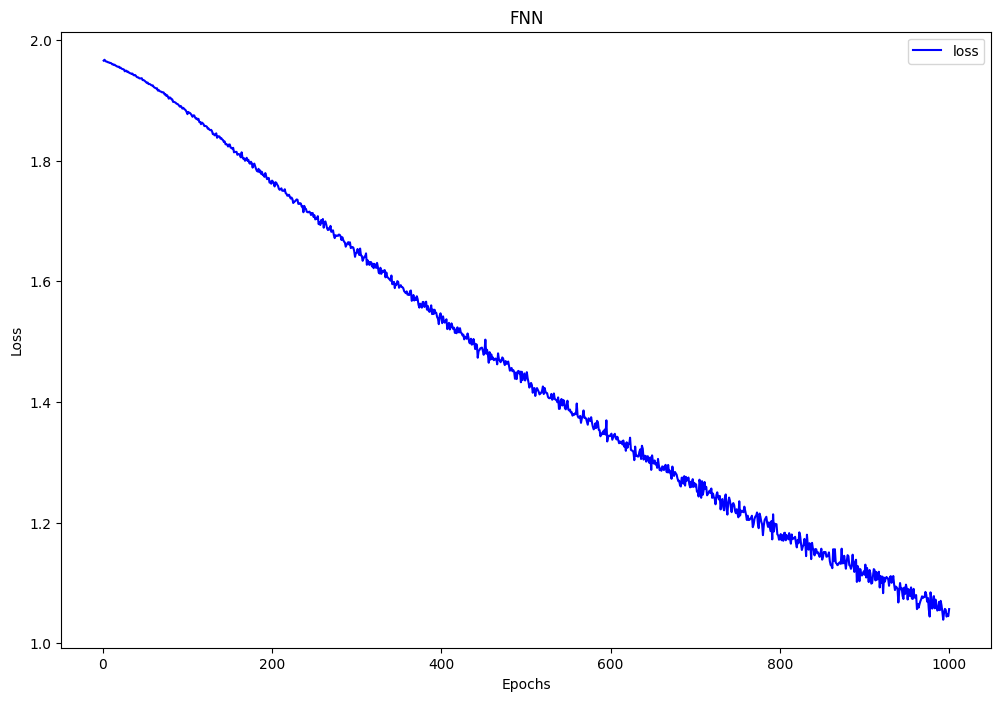

In [13]:
model.train()
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(graph)
    loss = loss_function(out, graph.y)
    loss = loss_function(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(12,8))
plt.title('FNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
losses_np = np.array(losses)
epoch_range = np.arange(1, epochs+1)
plt.plot(epoch_range, losses_np, color='blue', label='loss')
plt.legend()
plt.show()


In [14]:
##자동 노드 분류

model.eval()

with torch.no_grad():
    out = model(graph)
    pred = out.argmax(dim=1)
    test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]
    test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())
    print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.7232
